In [1]:
import braidz_analysis as bz
import matplotlib.pyplot as plt

2025-01-02 15:36:58,244 [INFO] 
Limited Linear Model Support Detected! 
---> PYCHEBFUN is not installed. 
---> Install pychebfun to use chebfun derivatives (https://github.com/pychebfun/pychebfun/) 
You can still use other methods 



In [2]:
root_folder = "/home/buchsbaum/mnt/nfc3008/md0/Experiments/"
exp_file = ["20241216_123918.braidz"]
exp_data = bz.braidz.read_braidz(root_folder + exp_file[0])

In [3]:
stim_raw_data = bz.processing.get_stim_or_opto_data(
    exp_data["df"], exp_data["stim"], duration=50
)
stim_centered_data = bz.processing.get_stim_or_opto_response_data(
    exp_data["df"], exp_data["stim"], duration=50
)

Amount of responsive flies for group <=15: 7
Amount of responsive flies for group >15: 11


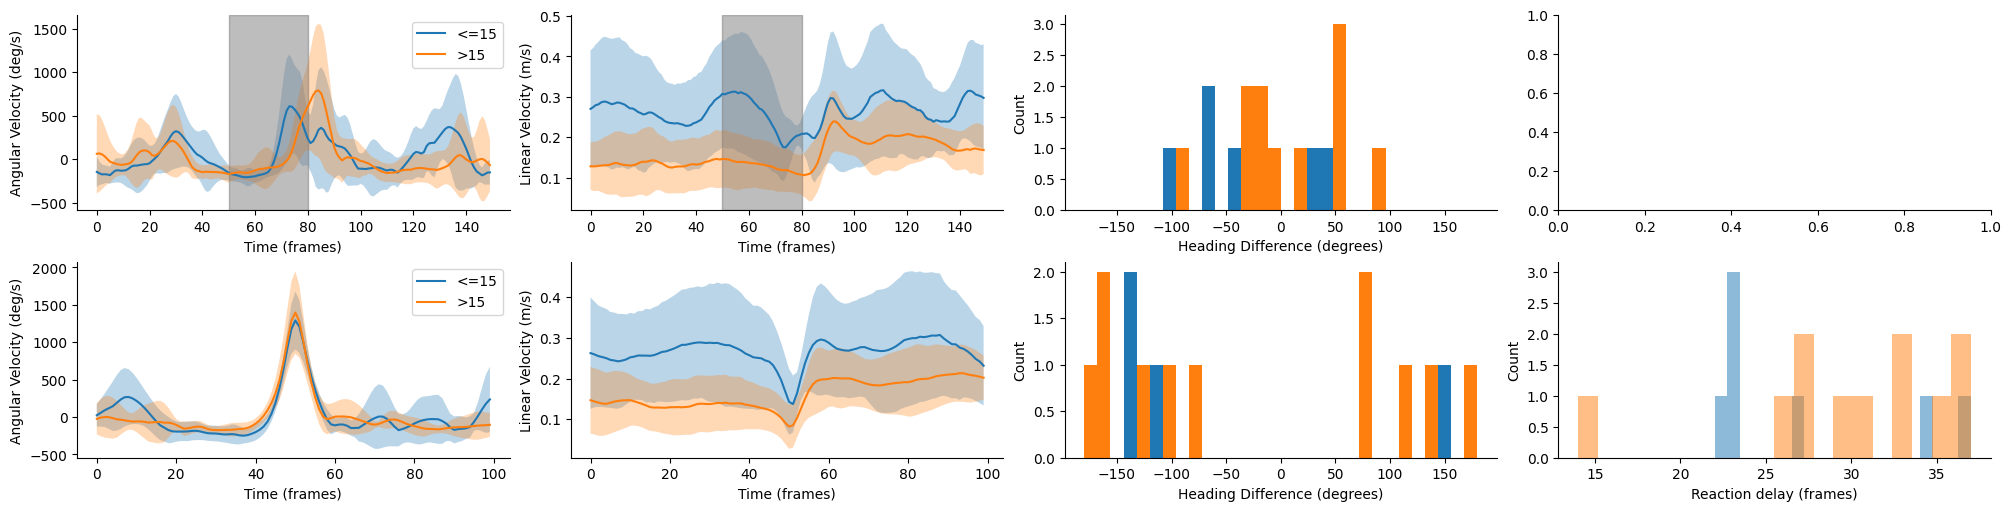

In [25]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 5), constrained_layout=True)

frames_in_radius_mask = bz.filtering.filter_by_frames_in_radius(stim_raw_data)
for k, v in frames_in_radius_mask.items():
    masked_data = bz.filtering.apply_mask(stim_raw_data, v)
    bz.plotting.plot_angular_velocity(
        masked_data,
        axs[0, 0],
        label=k,
        use_abs=True,
        baseline_range=(0, 50),
        convert_to_degrees=True,
    )
    bz.plotting.plot_linear_velocity(masked_data, axs[0, 1])
    bz.plotting.plot_heading_difference(masked_data, axs[0, 2], convert_to_degrees=True)

frames_in_radius_mask = bz.filtering.filter_by_frames_in_radius(stim_centered_data)
for k, v in frames_in_radius_mask.items():
    masked_data = bz.filtering.apply_mask(stim_centered_data, v)
    bz.plotting.plot_angular_velocity(
        masked_data,
        axs[1, 0],
        label=k,
        use_abs=True,
        baseline_range=(0, 50),
        convert_to_degrees=True,
        shaded_region=None,
    )
    bz.plotting.plot_linear_velocity(masked_data, axs[1, 1], shaded_region=None)
    bz.plotting.plot_heading_difference(masked_data, axs[1, 2], convert_to_degrees=True)
    bz.plotting.plot_histogram(
        masked_data["reaction_delay"], axs[1, 3], bins=20, alpha=0.5
    )
    print(f"Amount of responsive flies for group {k}: {sum(masked_data['responsive'])}")

for ax in axs.flatten():
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

axs[1, 3].set_xlabel("Reaction delay (frames)")
axs[1, 3].set_ylabel("Count")
axs[0, 0].legend()
axs[1, 0].legend()
plt.show()